In [1]:
import pandas as pd
import numpy as np

# specific for the 'best movies that need a watch plot'
from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, show
from bokeh.transform import jitter

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.transform import cumsum
from bokeh.palettes import Category10
from math import pi

In [2]:
file = "data/generated/films_reading.xlsx"
raw_stat = pd.read_excel(file)

In [3]:
output_notebook()

Loading BokehJS ...

In [4]:
unwatched = raw_stat[raw_stat['watched']==0]
genres = raw_stat.columns[21:45].to_list()
unwatched_per_genre = unwatched[
    ["tconst","primaryTitle","startYear","averageRating","numVotes","priority"]+genres].set_index("tconst")
unwatched_per_genre[genres] = unwatched_per_genre[genres].replace(np.NAN, 0).astype(int)


# get genre columns
tconst_genres = unwatched_per_genre[genres]

# replace 1's with column names
# HANDIG, sla op!!
# https://stackoverflow.com/questions/37032043/how-to-replace-a-value-in-a-pandas-dataframe-with-column-name-based-on-a-conditi
tconst_genres = tconst_genres.replace(1, pd.Series(tconst_genres.columns , tconst_genres.columns)).replace(0,pd.NA)

# convert genres frame from wide to long (HANDY!!)
tconst_genres = tconst_genres.unstack().to_frame().reset_index().drop(columns=['level_0']).rename(columns={0:'genre'})
tconst_genres = tconst_genres[tconst_genres['genre'].notna()].set_index('tconst')

# merge the genres
best_unwatched_per_genre = unwatched_per_genre[["primaryTitle","startYear","averageRating","numVotes",'priority']].merge(tconst_genres, how='left', on='tconst')

# add tconst
best_unwatched_per_genre["tconst"] = best_unwatched_per_genre.index

# keep the best 3 movies of every genre
best_3 = (best_unwatched_per_genre
          .sort_values('averageRating',ascending=False)
          .groupby('genre')
          .head(3))

# add priority movies
priority = best_unwatched_per_genre[best_unwatched_per_genre["priority"]==1]
movies_to_watch = pd.concat([best_3, priority], ignore_index=True).drop_duplicates()

# convert for plotting
movies_to_watch["ratingSize"] = np.exp(movies_to_watch["averageRating"]) / 100
movies_to_watch["numVotes"] = movies_to_watch["numVotes"].fillna(-300000)
movies_to_watch["ratingSize"] = movies_to_watch["ratingSize"].fillna(movies_to_watch["ratingSize"].median())
movies_to_watch['priority_color'] = movies_to_watch['priority'].fillna('blue').replace(1,'green')
movies_to_watch['priority'] = movies_to_watch['priority'].fillna('normal').replace(1,'priority')

## how do i plot this?


- je zou de categorien tegen elkaar kunnen plotten, met als rating de grootte van het puntje, de rest van de data maak je hoverbaar
- genre op de y as, rating op x as, numvotes als kleur, alle data hoverbaar
- Ik kan ook een heatmap maken

- 1. je maakt alle paren van categorien voor de films en een aparte kolom met alle regiseur data etc.
- 2. je maakt dezelfde plot als nu, maar dan met de categorien tegenover elkaar
- 3. kleur is populariteit, grootte is score

TODO:
- iets anders verzinnen zodat je niet meerdere plots krijgt per film
- hij moet nog kleuren
- als je klikt krijg je de imdb pagina

https://docs.bokeh.org/en/0.10.0/docs/user_guide/interaction.html

In [12]:


# make figure interactive
source = ColumnDataSource(movies_to_watch)

# initialize figure
p = figure(width=1000, height=1000, y_range=genres,
           title="Best movies that need a watch (size = score)",
           toolbar_location=None,
           tools="hover", tooltips="@primaryTitle, @startYear, @tconst, @genre, rating: @averageRating"
           )

# add objects to figure
p.scatter(x='numVotes', y=jitter('genre', width=0.6, range=p.y_range),
          source=source,
          alpha=0.2,
          size="ratingSize",
          color='priority_color',
          legend_group='priority')

# add urls (I think this works only in bokeh 3.x)
url = "https://www.imdb.com/title/@tconst/"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

# add labels to figure
p.xgrid.grid_line_color = None
p.yaxis.axis_label = 'genres'
p.xaxis.axis_label = 'popularity'

show(p)

# prepare data

In [4]:
watched_pie = raw_stat["watched"].replace({1:'watched', 0:'unwatched'}).value_counts().to_frame().reset_index().rename(columns={'index': 'status','watched':'count'})
watched_pie['angle'] = watched_pie['count']/watched_pie['count'].sum() * 2*pi
watched_pie['color'] = Category10[3][1:3]

In [5]:
p = figure(height=350, title="watched movies", toolbar_location=None,
           tools="hover", tooltips="@status: @count", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='status', source=watched_pie)

p.axis.axis_label = None
p.axis.visible = False
p.grid.grid_line_color = None

show(p)

# things to plot
## unwatched movies
- the 10 best unwatched movies
- movies that are less popular, but have relative high scores
- the 3 best movies per genre


## watched movies
je kan namen van films, acteurs, genres etc gewoon een labeltje geven als je hovert. dan hoef je geen extra as label te maken!!

- in the last 2 years
    - top 5 favorite genres
    - top 5 favorite actors
    - top 5 worst movies
- all time
    - top 5 favorite
        - directors
        - writers
        - actors (man vs women)
        - actor duo's
        - producer
        - genre combinations
        - movie years
        - per genre:
            - directors
            - actors
            - movies
        - non-english
    - favorite movies (4/4)
      - directors
      - writers
    - ratings: https://www.reddit.com/r/dataisbeautiful/comments/ajtfng/mpaa_movie_ratings_by_year_oc/
    - genre by year https://www.reddit.com/r/dataisbeautiful/comments/10hiat/percentage_of_films_made_in_each_genre_by_year/
- per time period release:  1900's, 1910's, 1920's etc
    - top 5 favorite 
        - movies
        - directors
        - writers
        - actors
        - producer
        - genre
- combinations:
    - movie genres: https://www.reddit.com/r/dataisbeautiful/comments/g2f3ip/oc_most_popular_movie_genre_combinations/
    - actors and genres
    - de 3 beste films van mijn 5 favoriete genres




# 3 best unwatched movies per genre

In [16]:
unwatched = raw_stat[raw_stat['watched']==0]
genres = raw_stat.columns[21:45].to_list()
unwatched_per_genre = unwatched[
    ["tconst","primaryTitle","startYear","averageRating","numVotes","priority"]+genres].set_index("tconst")
unwatched_per_genre[["startYear","numVotes"]] = unwatched_per_genre[["startYear","numVotes"]].astype('Int64')
unwatched_per_genre[genres+['priority']] = unwatched_per_genre[genres+['priority']].fillna(0).astype(int)

In [17]:
unwatched_per_genre

,primaryTitle,startYear,averageRating,numVotes,priority,Action,Adventure,Animation,Biography,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
tconst,,,,,,,,,,,,,,,,,,,,,
tt0108052,Schindler's List,1993,9.0,1415577,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
tt0088178,Stop Making Sense,1984,8.7,18360,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0245429,Spirited Away,2001,8.6,816805,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0103064,Terminator 2: Judgment Day,1991,8.6,1147922,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
tt0114814,The Usual Suspects,1995,8.5,1124130,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt17044106,Teacher's Pet,2024,NaN,<NA>,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
tt21192142,All of Us Strangers,2023,NaN,<NA>,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
tt23724682,Outcome,2023,NaN,<NA>,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


priotities moeten er nog geforceerd in

In [107]:
genres

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western']

# something new here

In [51]:
# get scored genres
genres = raw_stat.columns[21:45].to_list()
scores_per_genre = raw_stat[genres+['enjoyment']]
scores_per_genre[~scores_per_genre['enjoyment'].isna()]

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Mystery,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,enjoyment
370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
371,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
372,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
374,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
887,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
889,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
893,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [3]:
# getting data
genres = raw_stat.columns.values.tolist()[15:38]
watched = raw_stat.loc[raw_stat.loc[:,"watched"]==1]
watched_genre_scores = watched.loc[:,genres+['averageRating']]

# multiplying occurrence matrix with score
for i, row in watched_genre_scores[genres].iterrows():
    watched_genre_scores.loc[i] = row * watched.loc[i,'averageRating']

# removing averageRating
watched_genre_scores = watched_genre_scores.drop(columns="averageRating")

# converting occurrence matrix
watched_genre_scores = watched_genre_scores.melt()

# removing null values
watched_genre_scores = watched_genre_scores.query('value > 0')

TypeError: can't multiply sequence by non-int of type 'float'

# plot data

I need to find a plot that can combine the info from a boxplot of density graph with the amount of movies i watched of every genre.
overlapping density plots would be chaotic.

<AxesSubplot:title={'center':'value'}, xlabel='[variable]'>

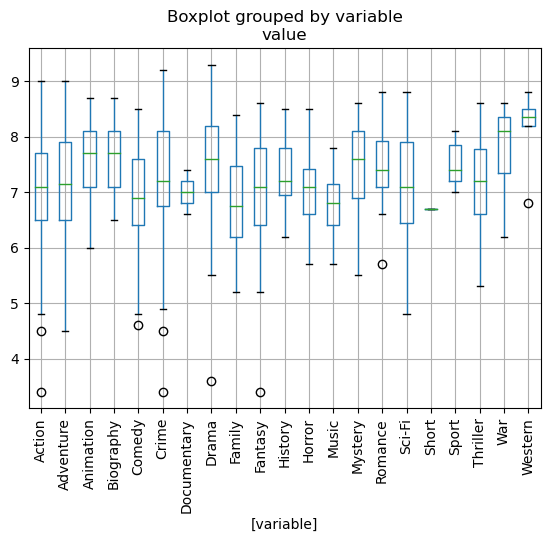

In [4]:
watched_genre_scores.boxplot(by='variable', rot=90)

<AxesSubplot:xlabel='variable'>

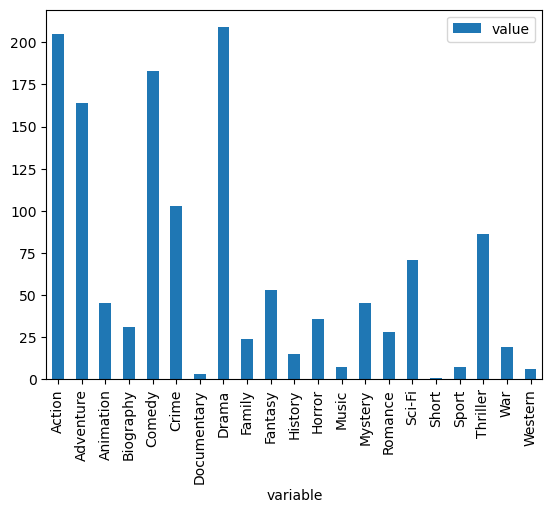

In [5]:
watched_genre_scores.groupby('variable').count().plot.bar()

This plot sucks

<AxesSubplot:ylabel='Frequency'>

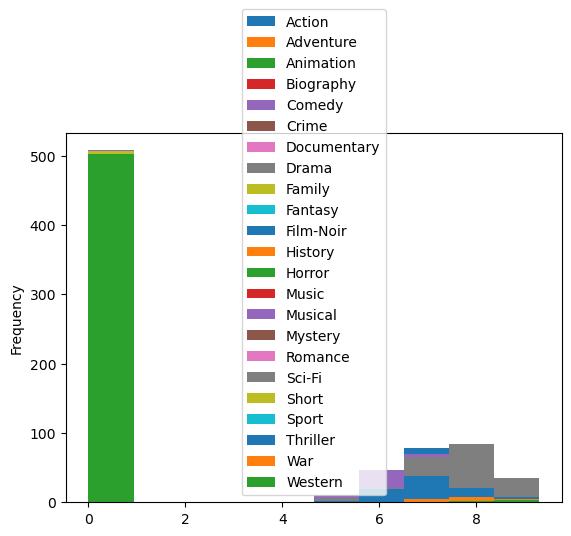

In [6]:
# getting data
genres = raw_stat.columns.values.tolist()[15:38]
watched = raw_stat.loc[raw_stat.loc[:,"watched"]==1]
watched_genre_scores = watched.loc[:,genres+['averageRating']]

# multiplying occurrence matrix with score
for i, row in watched_genre_scores[genres].iterrows():
    watched_genre_scores.loc[i] = row * watched.loc[i,'averageRating']

# removing averageRating
watched_genre_scores = watched_genre_scores.drop(columns="averageRating")

watched_genre_scores.plot.hist()